In [2]:
import os
import pickle
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

sns.set_context("paper")
    
# Set the font to be serif, rather than sans
sns.set(font='serif')
    
# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))
plt.rc('text', usetex=True)

os.chdir('PATH/code/zsl_text_imagenet/') # https://github.com/sebastianbujwid/zsl_text_imagenet

In [3]:
from matplotlib import rc

In [4]:
logging.basicConfig(level=logging.INFO)

In [5]:
from definitions import ROOT_DIR
from data import imagenet
import matching

In [6]:
overwrite_config = {
}


configs = [
    ROOT_DIR / 'configs' / 'env_config.yml',
    ROOT_DIR / 'configs' / 'matching_config.yml',
]

config = OmegaConf.merge(
    OmegaConf.load(str(configs[0])),
    OmegaConf.load(str(configs[1])),
    OmegaConf.create(overwrite_config))
OmegaConf.set_readonly(config, True)
OmegaConf.set_struct(config, True)

args = {
}
args = OmegaConf.create(args)
OmegaConf.set_readonly(args, True)
OmegaConf.set_struct(args, True)

In [7]:
dataset_config = config.env.datasets.ImageNet

In [8]:
imagenet_id_details = imagenet.extract_imagenet_id_details(dataset_config['imagenet_ids_to_wordnet'])
wnid_to_imagenet_id = imagenet.extract_wordnet_to_imagenet_id(dataset_config['imagenet_ids_to_wordnet'])

In [9]:
def class_details(wnid):
    imagenet_id = wnid_to_imagenet_id[wnid]
    return imagenet_id_details[imagenet_id]

In [10]:
class_details('n04004475')

('n04004475', ['printer', 'printing machine'])

In [11]:
albert_results_file = 'PATH/cada_vae/zls/eval/mp500/albert-xxlarge-v2_wiki_ALL/runrs-xxl_ALL-1013/lexp_run001/2020-05-25_04-45-31_N_N/test_results_mp500.pkl'
albert_results = pickle.load(open(albert_results_file, 'rb'))

In [13]:
# https://github.com/sebastianbujwid/ImageNet-Wiki_dataset/tree/main/class_article_text_descriptions
mp500_articles_file = 'PATH/ImageNet-Wiki_dataset/class_article_text_descriptions_mp500.pkl'
mp500_articles = pickle.load(open(mp500_articles_file, 'rb'))

In [14]:
len(mp500_articles), len(albert_results['test_unseen_top5_acc'])

(489, 489)

In [15]:
albert_results.keys()

dict_keys(['test_unseen_top1_acc', 'test_unseen_top1_acc_mean', 'test_unseen_top1_acc_mean_allclasses', 'test_unseen_top5_acc', 'test_unseen_top5_acc_mean', 'test_unseen_top5_acc_mean_allclasses'])

In [16]:
top5_acc_by_articles_length = []

for imagenet_id, v in mp500_articles.items():
    wnid = v['wnid']
    res = albert_results['test_unseen_top5_acc'][wnid]
    articles_length = 0
    for article in v['articles']:
        articles_length += len(article)
    
    top5_acc_by_articles_length.append((wnid, res, articles_length))

In [17]:
top5_acc_by_articles_length

[('n03114379', 0.44781342, 4059),
 ('n03898633', 0.5575723, 10322),
 ('n02820210', 0.79416716, 7209),
 ('n02699770', 0.95556873, 10176),
 ('n02739550', 0.97427016, 4867),
 ('n03380724', 0.09392611, 2600),
 ('n00464894', 0.46130952, 53017),
 ('n01787835', 0.8612863, 31198),
 ('n04477219', 0.56330085, 15701),
 ('n02891788', 0.053421367, 26412),
 ('n02084071', 0.42420462, 9144),
 ('n02918595', 0.17114304, 17687),
 ('n04478512', 0.118945435, 3073),
 ('n03548402', 0.22740033, 7617),
 ('n02987492', 0.0723115, 14932),
 ('n04217882', 0.8202934, 16506),
 ('n09988063', 0.013998782, 16284),
 ('n00442847', 0.69172496, 20506),
 ('n03309808', 0.21083628, 17244),
 ('n12282933', 0.0665881, 6497),
 ('n01318894', 0.34057072, 21846),
 ('n03986704', 0.49845773, 4728),
 ('n04388743', 0.47380033, 13034),
 ('n04020298', 0.021726366, 7417),
 ('n02430045', 0.72738093, 53010),
 ('n03219135', 0.5717514, 18898),
 ('n03525074', 0.18774593, 6941),
 ('n03613592', 0.5702833, 48473),
 ('n04381587', 0.750233, 37659),
 

In [18]:
import scipy.stats

In [19]:
def r2(x, y):
    return scipy.stats.linregress(x, y).rvalue**2

In [21]:
def plot_fig(df, group=None, save=None):
    x, y = select_group(df, group)
    sns.regplot(x=x, y=y, marker='x',
                scatter_kws={"s": 10, 'alpha': 0.5},
               )
    #sns.jointplot(x, y, kind='reg', sta)
    plt.xlabel('$\log_{10}$\, class description length (in \# of characters)')
    plt.ylabel('Top-5 mean class accuracy')
    plt.text(x.min(), y.max() * 0.9, f'$R^2={r2(x, y):.3f}$')
    if save:
        plt.savefig(f'{save}.pdf', bbox_inches='tight')
    plt.show()

In [25]:
groups = pickle.load(open('PATH/code/zsl_methods_imagenet/notebooks/excluding_groups/mp500_groups.pkl', 'rb'))

In [26]:
wnids, accs, lengths = zip(*top5_acc_by_articles_length)

In [27]:
def wnid_to_groupname(wnid):
    if wnid in groups['animals']:
        return 'animals'
    elif wnid in groups['plants']:
        return 'plants'
    elif wnid in groups['other']:
        return 'other'
    else:
        raise ValueError(wnid)

In [28]:
df = pd.DataFrame.from_dict(
{
    'wnid': wnids,
    'acc': accs,
    'length': lengths,
    'group': list(map(wnid_to_groupname, wnids)),
})

In [29]:
def select_group(df, group=None):
    if group:
        sel = df[df['group'] == group]
    else:
        sel = df
    x = np.log10(np.array(sel['length']))
    y = np.array(sel['acc'])
    return x, y

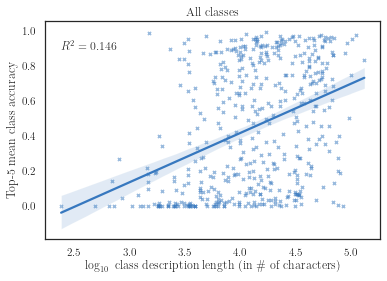

In [31]:
plt.title('All classes')
plot_fig(df, save='class_accuracy_vs_description_length')

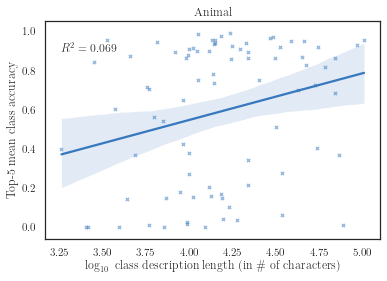

In [33]:
plt.title('Animal')
plot_fig(df, 'animals', save='class_accuracy_vs_description_length_animals')

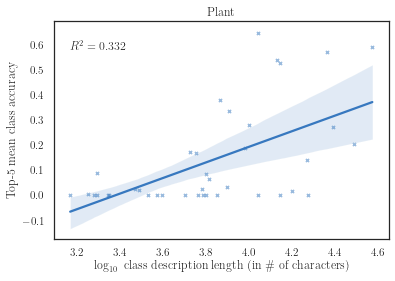

In [34]:
plt.title('Plant')
plot_fig(df, 'plants', save='class_accuracy_vs_description_length_plants')

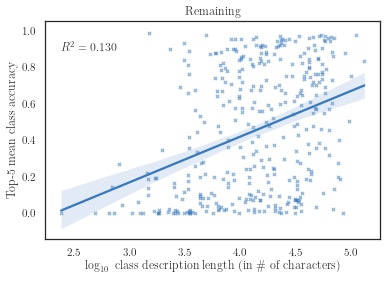

In [35]:
plt.title('Remaining')
plot_fig(df, 'other', save='class_accuracy_vs_description_length_other')